<a href="https://colab.research.google.com/github/godhin/used_retail/blob/main/jungonara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
df = pd.read_csv('/content/drive/MyDrive/used_mobile_phone.csv')

# EDA

In [40]:
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


In [41]:
df['month'] = df['create_date'].apply(lambda x: x[:7]) # 월별로 표시하기위해 추출

In [42]:
df['month'].value_counts() # 월별 거래 횟수를 계산

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

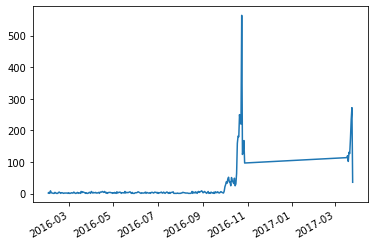

In [43]:
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()

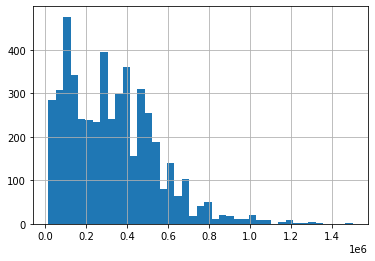

In [44]:
df['price'].hist(bins="auto")

In [45]:
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x)) # 핸드폰 기종별 평균
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x)) # 핸드폰 기종별 표준편차

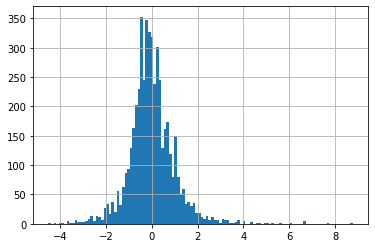

In [46]:
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std # z_score 계산
df_price_model_z_score.hist(bins="auto")

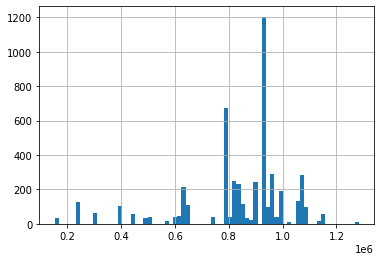

In [47]:
df['factory_price'].hist(bins="auto") # 분포도를 탐색한다.

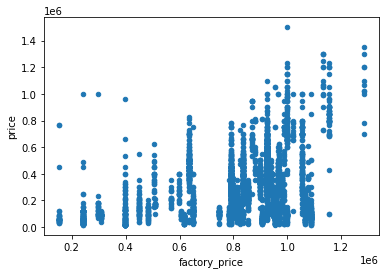

In [48]:
df.plot.scatter(x='factory_price', y='price') # 출고가와 중고가격의 상관관계를 살펴본다.

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64


{'boxes': [<matplotlib.lines.Line2D at 0x7fb251d92490>],
 'caps': [<matplotlib.lines.Line2D at 0x7fb251d97550>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb251d9f590>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fb251d9f050>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fb251d92a90>,
  <matplotlib.lines.Line2D at 0x7fb251d92fd0>]}

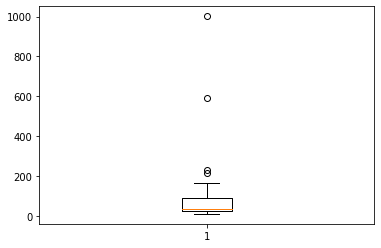

In [49]:
# 기종별 총 거래 데이터 개수를 집계
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())

# 기종별 총 거래 데이터 개수를 박스플롯
plt.boxplot(model_counts)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [51]:
df

,create_date,price,text,phone_model,factory_price,maker,price_index,month
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,2017-03
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05,2016-10
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05,2016-10
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96,2017-03
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59,2016-04
...,...,...,...,...,...,...,...,...
4946,2016-10-10 11 29 00 AM,1300000.0,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉\t ...,iphone 7 plus 256gb,1283700,apple,103.05,2016-10
4947,2016-10-24 10 03 00 PM,1300000.0,미국판 아이폰7 256g 제트블랙 강남역삼 2대 미개봉언락 애플 a1660 강남역삼...,iphone 7 256gb,1130800,apple,103.05,2016-10
4948,2016-09-19 10 15 00 AM,1300000.0,"아이폰7 미개봉 홍콩판 팝니다 케이스,강화유리서비스 종류다양 아이폰7 917,91...",iphone 7 256gb,1130800,apple,103.05,2016-09
4949,2016-10-05 12 22 00 AM,1350000.0,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉 미개...,iphone 7 plus 256gb,1283700,apple,103.05,2016-10


In [52]:
df = df[['price', 'phone_model', 'factory_price', 'maker', 'price_index', 'month']]
df = pd.get_dummies(df, columns=['phone_model', 'maker', 'month'])
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # 데이터를 학습/테스트용으로 분리한다.

In [53]:
# 랜덤 포레스트 모델을 학습
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


In [54]:
# 학습한 모델을 평가
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 10631643789.047, test: 13872395437.933
R^2 train: 0.781, test: 0.683


In [55]:
feat_labels = X.columns.tolist() # 학습한 모델의 피처 중요도를 확인
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

[('factory_price', 0.4066026428548887),
 ('maker_apple', 0.2971477416609539),
 ('phone_model_galaxy s3 3g 8gb', 0.022529363254131334),
 ('phone_model_iphone se 64gb', 0.021681292092517176),
 ('price_index', 0.02073830684620235),
 ('phone_model_galaxy s4 32gb', 0.016924097101693042),
 ('month_2017-03', 0.014855979123344513),
 ('maker_samsung', 0.014531370182012903),
 ('phone_model_galaxy s6 32gb', 0.01258159974166804),
 ('month_2016-05', 0.010968428641856052)]

<BarContainer object of 84 artists>

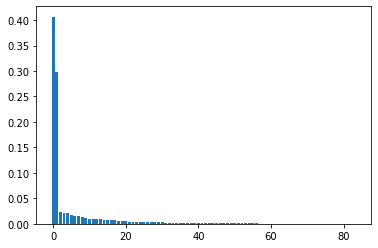

In [56]:
importances = forest.feature_importances_ # 피쳐 중요도를 그래프로 표시
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

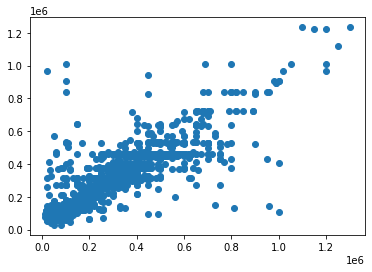

In [57]:
plt.scatter(y_test.values, y_test_pred) # 예측결과를 scatter plot으로 표시

In [58]:
# 데이터를 다시 불러옵니다.
df = pd.read_csv("/content/drive/MyDrive/used_mobile_phone.csv")

In [59]:
from datetime import datetime
import time

# create_date 피처를 수치적으로 계산하기 위해, unixtime으로 변환하는 함수를 정의
def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, '%Y-%m-%d').timetuple())
    return timestamp

# create_date 피처를 ‘현재와 얼마나 가까운 데이터인 지’ 판단하기 위한 점수를 생성합니다. 먼저 unixtime으로 데이터를 변환
df['create_unixtime'] = df['create_date'].apply(lambda x: date_to_unixtime(x[:10]))
print(df['create_unixtime'][:10])

0    1.489882e+09
1    1.477440e+09
2    1.477354e+09
3    1.490227e+09
4    1.460333e+09
5    1.490141e+09
6    1.490227e+09
7    1.475798e+09
8    1.490400e+09
9    1.458691e+09
Name: create_unixtime, dtype: float64


In [60]:
# 변환된 unixtime에 min-max 스케일링을 적용
df['create_time_score'] = (df['create_unixtime'] - df['create_unixtime'].min()) / \
                          (df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date', 'create_unixtime', 'create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,1.489882e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477440e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477354e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490227e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460333e+09,0.165468


In [61]:
# phone_model 피처에서 저장 용량(phone_model_storage) 피처를 추출
df['phone_model_storage'] = df['phone_model'].apply(lambda x: x.split(" ")[-1])

# phone_model 피처에서 기종 세부명(phone_model_detail) 피처를 추출
df['phone_model_detail'] = df['phone_model'].apply(lambda x: ' '.join(x.split(" ")[:-1]))
df[['phone_model_storage', 'phone_model_detail']].head()

,phone_model_storage,phone_model_detail
0,64gb,iphone 6
1,32gb,galaxy s6 edge
2,32gb,galaxy s6
3,32gb,lg g5
4,32gb,lg u


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


{'boxes': [<matplotlib.lines.Line2D at 0x7fb251a85d50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb251a8ddd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb251a13e10>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fb251a138d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fb251a8d350>,
  <matplotlib.lines.Line2D at 0x7fb251a1be10>]}

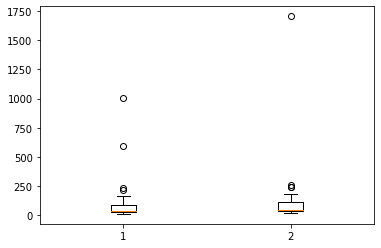

In [62]:
# phone_model 피처의 기종별 거래 데이터 개수를 집계
model_counts = df['phone_model'].value_counts()

# phone_model_detail 피처의 기종별 거래 데이터 개수를 집계
model_detail_counts = df['phone_model_detail'].value_counts()
data = [model_counts, model_detail_counts]

# 두 피처간의 기종별 거래 데이터 개수를 비교
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.boxplot(data)

In [63]:
# 기종명 + 용량으로 출고가를 찾기 위한 딕셔너리를 생성
model_to_factory_price_dict = {}
for index, row in df.iterrows():
    model_concat = (row['phone_model_detail'], row['phone_model_storage'])
    if model_concat in model_to_factory_price_dict:
        pass
    else:
        model_to_factory_price_dict[model_concat] = row['factory_price']
print(str(model_to_factory_price_dict)[:40], "...")

{('iphone 6', '64gb'): 924000, ('galaxy  ...


-1.3966616903783426
1.666982156397844


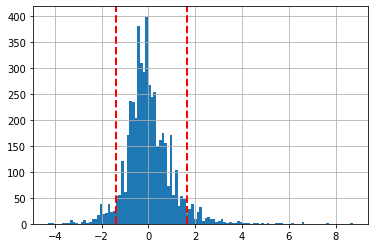

In [64]:
# 거래 가격(price)의 z-score를 계산합니다. 이는 해당 데이터의 가격이 기종의 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수
df['price_by_group'] = df.groupby('phone_model_detail')['price'].transform(lambda x: (x - x.mean()) / x.std())

# 거래 가격의 z-score(price_by_group)의 분포를 그래프로 출력합니다
ax = df['price_by_group'].hist(bins="auto")

# z-score(price_by_group) 기준으로 하위 5%, 상위 5%에 해당하는 점수를 lower_bound, upper_bound 라고 지정
lower_bound = df['price_by_group'].quantile(0.05)
upper_bound = df['price_by_group'].quantile(0.95)

# lower_bound, upper_bound 그래프에 추가
ax.axvline(x=lower_bound, color='r', linestyle='dashed', linewidth=2)
ax.axvline(x=upper_bound, color='r', linestyle='dashed', linewidth=2)

# lower_bound를, upper_bound 출력
print(lower_bound)
print(upper_bound)

In [65]:
# lower_bound보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류하는 함수를 정의
def get_price_level(price, lower, upper):
    if price <= lower:
        return "0"
    elif price >= upper:
        return "2"
    else:
        return "1"

# lower_bound보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류
df['price_lower'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.05))
df['price_upper'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.95))
df['price_level'] = df.apply(lambda row: get_price_level(row['price'], row['price_lower'], 
                                                         row['price_upper']), axis=1)
df[['price', 'price_lower', 'price_upper', 'price_level', 'text']].head()

,price,price_lower,price_upper,price_level,text
0,550000.0,180000.0,680000.0,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.0,180000.0,414000.0,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.0,150000.0,349000.0,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.0,100000.0,500000.0,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.0,18000.0,400000.0,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...


In [66]:
import pickle
import re

# 중고나라 불용어 사전을 불러옵니다.
with open('/content/drive/MyDrive/used_mobile_phone_stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)

# 불용어 사전에 등록된 단어
print(stopwords)

['거래', '입니', '판매', '아이폰', '갤럭시', '골드', '팝', '만원', '폰', '시', '주세', '노트', '문자', '화이트', '연락', '블랙', '구매', '및', '기재', '년', '품', '월', '용', '로즈', '상세', '항목', '완료', '지역', '개', '실버', '신청하기', '색상', '타', '기기', '서울', '후', '문의', '원', '설명', '판', '전화', '엣지', '모두', '경우', '보시', '위', '정확히', '정도', '될', '등', '휴대폰', '되', '일', '플러스', 'g', 'lg', 'skt', 'gb', 'kt', 'sk', 'se', 'lgu', 'u', 'lte', 'fl', 'ltea', 'nl', 'k', 'z', 'v', 'lgt', 'gs', 'gl', 'ss', 'cat', 'nk', 'b', 'com', 'gpro', 'ea', 'ns', 'ios', 'gt', 'or', 'usb', 'amp', 'umi', 'lgfl', 'es', 'howufeel', 'gk', 'ek', 'xperia', 'y', 'wpi', 'mtk', 'd', 'www', 'sss', 'fs', 'el', 'lglp', 'white', 'http', 'o', 'l', 'zv', 'e', 'al', 'gn', 'ps', 'naver', 'rome', 'gx', 'lglb', 'ssanmai', 'f', '계', '명', '들', '적', '자', '상', '화', '대', '중', '장', '간', '네', '분', '권', '이', '백', '째', '형', '분들', '번째', '씩', '쯤', '식', '조', '성', '꺼', '님', '당', '인', '틱', '짱', '샵', '군', '천', '아', '플', '흡', '휴', '엑', ',', ',,', '+,', '++++++++++++++++++++++++++++++++++++++', ',,,,,,', '그리고

In [70]:
!pip install konlpy # nlp 한국어 정보처리를 위해 사용하는 패키지를 설치
# 코엔엘파이

     |████████████████████████████████| 19.4 MB 1.1 MB/s 
     |████████████████████████████████| 448 kB 68.1 MB/s 


In [72]:
from konlpy.tag import Okt

# ‘+’를 제외한 특수문자를 제거하고, 숫자형태의 문자를 제거
def text_cleaning(text):
    text = ''.join(c for c in text if c.isalnum() or c in '+, ')
    text = ''.join([i for i in text if not i.isdigit()])
    return text

# 불용어에 등장하지 않는 형태소만을 추출하여 반환하는 함수
def get_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] not in stopwords]

# 위 함수들을 적용한 형태소 추출을 테스트합니다.
df['text'] = df['text'].apply(lambda x: text_cleaning(x))
result = get_pos(df['text'][0])
print(result)

['+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '징', '애플', '라이트', '홈', '버튼', '링', '카메라', '링', '볼륨', '버튼', '슬립', '버튼', '검금', '심플', '튀지', '않게', '이쁘게', '했구요', '유심', '꽂고', '바로', '사용', '하시면', '됩니다', '사람', '이냐', '자주', '물어보고', '실제', '더욱', '이쁩니다', '밤', '영롱하게', '맥북', '뒷', '사과', '로고', '비춰지고', '요전', '넘어가기', '위해', '합니다', '가능합니다', '박스', '어머니', '버리시고', '이어폰', '충전기', '정품', '드립니다', '직거래', '우선', '순', '위로', '정', '싶으시면', '선', '입금', '택배', '발송', '해드리겠습니다', '믿으시면', '직거래', '하시길', '추천', '해요', '안전', '합니다', '서울시', '강남구', '역삼동', '차병원', '사거리', '근처', '가격']


In [73]:
from collections import Counter

# get_pos 함수를 모든 텍스트 데이터에 적용하여 형태소 말뭉치를 추출
corpus = sum(df['text'].apply(lambda x: get_pos(x)).tolist(), [])

# 추출된 형태소 말뭉치에서 가장 많이 등장한 형태소 2500개를 추출
counter = Counter(corpus)
common_words = [key for key, _ in counter.most_common(2500)]
common_words

['입니다',
 '직거래',
 's',
 '합니다',
 '택배',
 '사용',
 '급',
 '상태',
 '팝니다',
 '가능합니다',
 '정상',
 '사진',
 '가격',
 '+',
 '케이스',
 'a',
 '주세요',
 '해지',
 '삭제',
 '제품',
 '있습니다',
 '박스',
 '가능',
 '직접',
 '액정',
 '배터리',
 '성품',
 '필름',
 '리퍼',
 '충전기',
 '없습니다',
 '풀',
 '개통',
 '유심',
 '즈',
 '안전',
 '스',
 '하기',
 '신청',
 '드립니다',
 '통신사',
 '구입',
 '약정',
 '이어폰',
 '공기',
 '새',
 '기변',
 '포함',
 '모델',
 '선택',
 '됩니다',
 '확인',
 '기간',
 '기스',
 '그레이',
 '찍힘',
 '방법',
 '바로',
 '할인',
 '제',
 '시기',
 '스페이스',
 '희망',
 '번호',
 '중고나라',
 '본체',
 '같이',
 '생활',
 '잘',
 '무',
 '퀵',
 '글',
 '된',
 '않을',
 '공식',
 '앱',
 '확정',
 '기능',
 '다운',
 '양',
 '호환',
 '케이블',
 '받기',
 '미',
 '이메일',
 '작성',
 '부분',
 '금지',
 '될수',
 '식아이디',
 '허위',
 '임의',
 '통보',
 '채우지',
 '핸드폰',
 '편한',
 '전혀',
 '충전',
 '내용',
 '연락처',
 '단말기',
 '부산',
 '대구',
 '미사',
 '정품',
 '중고',
 '문제',
 '없이',
 '이상',
 '보호',
 '방문',
 '없는',
 '외관',
 '외',
 '인천',
 '깨끗합니다',
 'x',
 '초기',
 '하나',
 '참고',
 '이구',
 '요금',
 '개월',
 '이나',
 '사이트',
 '팔아요',
 '하시면',
 '했습니다',
 '동',
 '카페',
 '보내',
 '카톡',
 '블로그',
 '링크',
 '싸이',
 '강퇴',
 '삼성',
 '거치',
 '있는',
 '호선'

In [74]:
df['price_level'].value_counts()

1    4296
0     334
2     321
Name: price_level, dtype: int64

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 빈출 형태소를 제외한 모든 형태소를 제거하는 함수를 정의
def get_common_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] in common_words]

# 1:3:1 비율로 랜덤 샘플링을 수행
negative_random = df[df['price_level']=='0'].sample(321, random_state=30)
neutral_random = df[df['price_level']=='1'].sample(321*3, random_state=30)
positive_random = df[df['price_level']=='2'].sample(321, random_state=30)

# 샘플링 완료된 데이터셋을 정의
df_sample = negative_random.append(neutral_random).append(positive_random)

# TF-IDF를 수행하여 피처를 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_common_pos(x))
X = index_vectorizer.fit_transform(df_sample['text'].tolist())
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

# 감성 분류를 위한 학습 데이터셋을 정의
y = df_sample['price_level']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)
print(x_train.shape)
print(x_test.shape)

(1284, 2476)
(321, 2476)


In [77]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# 비선형 SVM 분류 모델을 학습하고 평가
svm = SVC(kernel='rbf', C=10.0, random_state=0, gamma=0.10)
svm.fit(x_train, y_train)
y_pred_ksvc = svm.predict(x_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_ksvc))

Accuracy: 0.77


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


MSE train: 4775588807.152, test: 11079547216.086
R^2 train: 0.902, test: 0.747


[('factory_price', 0.25373165101970097),
 ('maker_apple', 0.2534443713383566),
 ('create_time_score', 0.11633999833574118),
 ('phone_model_storage_16gb', 0.06158720625590143),
 ('product_status_2', 0.04725456176998206),
 ('phone_model_detail_galaxy s7 edge', 0.0290869227484893),
 ('phone_model_detail_galaxy note5', 0.02509162974970531),
 ('phone_model_storage_64gb', 0.024843480566792486),
 ('phone_model_detail_galaxy s7', 0.02288706140123361),
 ('product_status_0', 0.02152829624015401)]

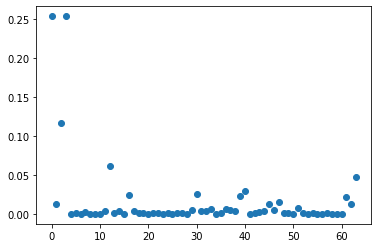

In [78]:
# text 피처로부터  '상품 상태 피처(product_status)' 를 생성
X = index_vectorizer.transform(df['text'].tolist())
X = tfidf_vectorizer.transform(X)
df['product_status'] = pd.Series(svm.predict(X))

# 랜덤 포레스트 모델 학습을 위한 데이터를 준비
df = df[['price', 'factory_price', 'maker', 'price_index', 'create_time_score', 'phone_model_storage',
                'phone_model_detail', 'product_status']]
df = pd.get_dummies(df, columns=['maker', 'phone_model_storage', 'phone_model_detail', 'product_status'])

# 학습/테스트 데이터를 분리합니다.
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 모델을 학습하고 평가
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 피처 중요도 plot을 출력
importances = forest.feature_importances_
plt.plot(importances, "o")

# 피처 중요도를 print로 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

In [79]:
# 프로그램에서 입력값에 대한 피처를 찾기 위한 딕셔너리를 생성
col_to_index_dict = {}
for idx, col in enumerate(df.columns[1:]):
    col_to_index_dict[col] = idx
    
print(str(col_to_index_dict)[:40], "...")

{'factory_price': 0, 'price_index': 1, ' ...


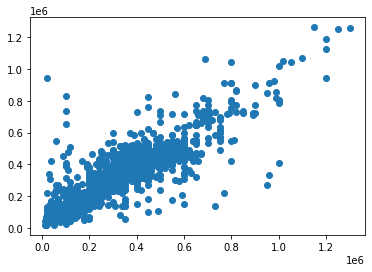

In [80]:
# 테스트 데이터의 y값과, 예측된 y값을 scatter plot을 활용하여 상관관계를 살펴보기
plt.scatter(y_test.values, y_test_pred)

In [81]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search로 찾아낼 파라미터 후보군을 각각 리스트로 선정
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]

# RandomizedSearchCV 오브젝트를 생성하여 모델을 정의
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
forest = RandomForestRegressor()
optimal_forest = RandomizedSearchCV(estimator = forest, 
                                    param_distributions = random_grid, 
                                    n_iter = 100, 
                                    cv = 3, 
                                    verbose=2,
                                    random_state=42, 
                                    n_jobs = -1)

# RandomizedSearchCV 모델을 학습
X = df.loc[:, df.columns != 'price']
y = df['price']
optimal_forest.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [82]:
# 앞서 선정한 파라미터 후보군 중에서 가장 좋은 결과를 보인 파라미터의 조합을 출력
optimal_forest.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 2000}

MSE train: 8808366908.731, test: 7645657916.890
R^2 train: 0.818, test: 0.825


[('factory_price', 0.296481036173569),
 ('maker_apple', 0.27561463937862957),
 ('phone_model_storage_16gb', 0.07214802274527568),
 ('create_time_score', 0.06570878854578828),
 ('product_status_2', 0.06264201981502726),
 ('phone_model_detail_galaxy s7 edge', 0.027077101499587954),
 ('phone_model_detail_iphone 6', 0.025032885174634152),
 ('product_status_0', 0.02445296842906688),
 ('phone_model_detail_galaxy s4', 0.02053025339097737),
 ('product_status_1', 0.01379091365416451)]

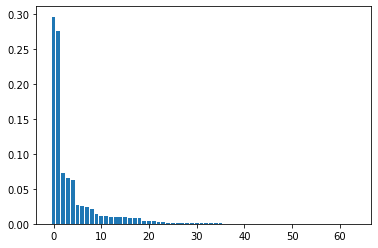

In [83]:
# 최적의 파라미터를 적용한 모델로 중고폰의 가격을 예측하고 평가
y_train_pred = optimal_forest.predict(X_train)
y_test_pred = optimal_forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 가격 예측 모델의 피처 중요도 plot을 출력
importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 가격 예측 모델의 피처 중요도를 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, optimal_forest.best_estimator_.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

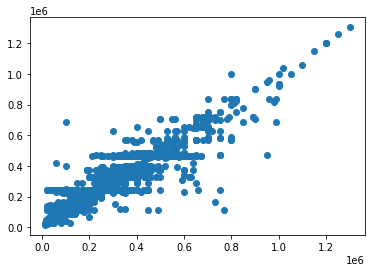

In [84]:
# 테스트 데이터의 y값과, 예측된 y값을 scatter plot을 활용하여 상관관계 확인
plt.scatter(y_test.values, y_test_pred)

In [85]:
import joblib

# 모델 예측을 위한 중간 오브젝트들을 각각 파일로 저장합니다.
with open('model_to_factory_price_dict.pickle', 'wb') as f:
    pickle.dump(model_to_factory_price_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('col_to_index_dict.pickle', 'wb') as f:
    pickle.dump(col_to_index_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('common_words.pickle', 'wb') as f:
    pickle.dump(common_words, f, pickle.HIGHEST_PROTOCOL)
    
with open('init_vectorizer_vocabulary.pickle', 'wb') as f:
    pickle.dump(index_vectorizer.vocabulary_, f, pickle.HIGHEST_PROTOCOL)
    
with open('tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f, pickle.HIGHEST_PROTOCOL)
    
with open('svm_classifier.pickle', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)

joblib.dump(optimal_forest.best_estimator_, 'rf_regressor.pickle', compress = 1)

['rf_regressor.pickle']